The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating PSF...Done


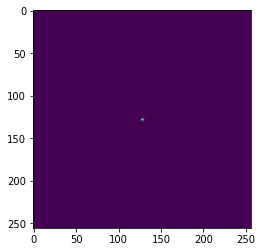

Voxel sizes: [ 10 106 106]
Image dimensions: (1, 10000, 10000)
Image dimensions nm: [      0 1060000 1060000]
10000 -34
10000 -34
Saved: /home/miguel/Projects/uni/data/smlm_3d/simulated_ideal_psf/nanopore/nanopore.ome.tif


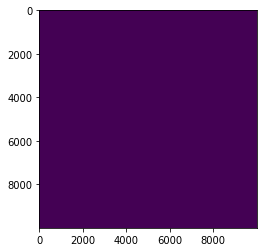

In [24]:
%load_ext autoreload
%autoreload 2

from tifffile import imwrite
from config.datasets import dataset_configs
from config.optics import bounds
from data.visualise import show_psf_axial, scatter_3d, scatter_yz
from debug_tools.dataset_simulator.sphere import sphere_center
from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration
from debug_tools.dataset_simulator.sphere import main as sphere_main, surface_density_nm2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
z_range = 1000

np.random.seed(42)
img_dim = (401, 1024, 1024)

def gen_fake_psf(model_kwargs):
    model = HanserPSF(**model_kwargs)
    # model = apply_named_aberration(model, 'oblique astigmatism', 2)
    model = apply_aberration(model, np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 0.5]))

    psf = model.PSFi
    psf = psf.astype(float)
    # psf = psf / psf.max()
    return psf


class SimulatedImage:
    background_noise = 0
    background_noise_var = 0.05

    def __init__(self, img_dim, voxel_sizes, psf):
        self.img_dim = img_dim
        self.voxel_sizes = voxel_sizes
        self.img = self.gen_empty_img()
        self.psf = psf
        self.img_dim_nm = np.product((self.img_dim, self.voxel_sizes), axis=0)
        self.n_emitters_in_image = 0
        print(f'Voxel sizes: {self.voxel_sizes}')
        print(f'Image dimensions: {self.img_dim_nm}')

    def gen_empty_img(self, img_dim=None):
        # img = np.random.normal(loc=self.background_noise, scale=self.background_noise_var, size=self.img_dim)
        img = np.zeros(img_dim or self.img_dim, dtype=np.float16)
        # base camera value
        img[:] = 1e-5
        img[img < 0] = 0
        return img

    def nm_to_pixel_coords(self, nm_coords):
        return [int(nm_coord / voxel_dim_size) for nm_coord, voxel_dim_size in zip(nm_coords, self.voxel_sizes)]

    def psf_center_to_anchor_coords(self, pixel_coords):
        return [c - int(psf_dim / 2) for c, psf_dim in zip(pixel_coords, self.psf.shape)]

    def filter_visible_emitters(self, coords):
        print(coords.min(axis=0))
        print(coords.max(axis=0))
        print(self.img_dim_nm)
        x_min, y_min, z_min = 0, 0, 0
        z_max, x_max, y_max = self.img_dim_nm
        idx = np.where((coords[:, 0] >= z_min)
                       & (coords[:, 0] < z_max)
                       & (coords[:, 1] >= x_min)
                       & (coords[:, 1] < x_max)
                       & (coords[:, 2] >= y_min)
                       & (coords[:, 2] < y_max))
        coords = coords[idx]
        return coords

    def add_emitter(self, nm_coords):
        center_pixel_coords = self.nm_to_pixel_coords(nm_coords)
        anchor_coords = self.psf_center_to_anchor_coords(center_pixel_coords)

        psf_shape = self.psf.shape
        z_start, z_end = anchor_coords[0], anchor_coords[0] + psf_shape[0]
        x_start, x_end = anchor_coords[1], anchor_coords[1] + psf_shape[1]
        y_start, y_end = anchor_coords[2], anchor_coords[2] + psf_shape[2]

        _psf = self.psf.copy()
        if z_start < 0:
            _psf = _psf[-z_start:]
            z_start = 0
        if z_end > self.img_dim[0]:
            _psf = _psf[:int(self.img_dim[0])-z_end]
            z_end = self.img_dim[0]

        if x_start < 0:
            _psf = _psf[:, -x_start:]
            x_start = 0
        if x_end > self.img_dim[1]:
            _psf = _psf[:, :int(self.img_dim[1])-x_end]
            x_end = self.img_dim[1]

        if y_start < 0:
            _psf = _psf[:, :, -y_start:]
            y_start = 0
        if y_end > self.img_dim[2]:
            _psf = _psf[:, :, :int(self.img_dim[2])-y_end]
            y_end = self.img_dim[2]

        self.img[z_start:z_end, x_start:x_end, y_start:y_end] += _psf

        self.n_emitters_in_image += 1
    
    @staticmethod
    def poisson_img(img):
        img = img / img.max()
        print(img.min(), img.max())
        img *= 1e3
        print(img.min(), img.max())
        img = np.random.poisson(img)
        img = img / img.max()
        return img

    def poisson_fov(self):
        self.img = self.poisson_img(self.img)

    def save(self, filepath):
        img = self.img.astype(np.float32)
        img = img / img.max()
        imwrite(filepath, img, compress=6)
        print(f'Saved: {filepath}')

    def center_sphere_in_image(self, coords):
        center = np.array(sphere_center)[[2, 0, 1]]
        img_center = self.img_dim_nm / 2
        for dim in [1, 2]:
            coords[:, dim] = coords[:, dim] - center[dim] + img_center[dim]
        coords[:, 0] = coords[:, 0] - coords[:, 0].min()
        coords[:, 0] += ((self.psf.shape[0]//2)*self.voxel_sizes[0])
        return coords


def add_emitters(img, coords):
    for localisation in coords:
        img.add_emitter(localisation)

def save_img(cfg, img):
    print(f'{img.n_emitters_in_image} emitters in image')

    img.poisson_fov()
    img_path = os.path.join(cfg['bpath'], cfg['img'])
    dirname = os.path.dirname(img_path)
    print(dirname)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    img.save(img_path)
    print(img_path)

def gen_sphere(dataset, psf):
    cfg = dataset['sphere_ground_truth']
    sphere_main(cfg, surface_density=surface_density_nm2)
    img = SimulatedImage(img_dim, cfg['voxel_sizes'], psf=psf)
    csv_file = os.path.join(cfg['bpath'], cfg['simulation_csv'])
    zxy_coords = pd.read_csv(csv_file)[['z', 'x', 'y']].to_numpy()
    zxy_coords = img.center_sphere_in_image(zxy_coords)
    zxy_coords = img.filter_visible_emitters(zxy_coords)
    scatter_3d(zxy_coords[:, [1, 2, 0]])
    add_emitters(img, zxy_coords)
    return img, cfg

from skspatial.objects import Plane
def tilt_points(img_dim_nm, zxy_coords):
    xyz_coords = zxy_coords[:, [1, 2, 0]]
    z, x, y = [x//2 for x in img_dim_nm]
    a, b, c, d = Plane(point=(x, y, z), normal=[1e-3, 1e-4, 1]).cartesian()
    map_z = lambda x, y: -(d + (a*x) + (b*y))/c
    xyz_coords[:, 2] = map_z(xyz_coords[:, 0], xyz_coords[:, 1])
    # print(xyz_coords[:, 2].min(), xyz_coords[:, 2].max())
    return xyz_coords[:, [2, 0, 1]]

def gen_bead_stack(cfg_type, psf):
    img = SimulatedImage(img_dim, voxel_sizes=cfg_type['training']['voxel_sizes'], psf=psf)
    cfg = cfg_type['training']
    lateral_range = img.img_dim_nm[1]
    median_z = img.img_dim_nm[0] / 2
    xy_area = img.img_dim_nm[1] * img.img_dim_nm[2]
    point_density = 5e-8
    n_points = int(point_density * xy_area)
    print(f'Placing {n_points} points')
    xy_coords = np.random.uniform(0, lateral_range, size=(n_points, 2))
    z_coords = np.array([median_z] * n_points)[:, np.newaxis]
    coords = np.concatenate((z_coords, xy_coords), axis=1)
    coords = tilt_points(img.img_dim_nm, coords)
    add_emitters(img, coords)
    return img, cfg

def gen_psf(cfg):
    print('Generating PSF...', end='')
    model_kwargs = dict(
        wl=cfg['wl'],
        na=1.3,
        ni=1.51,
        res=cfg['voxel_sizes'][1],
        zres=cfg['voxel_sizes'][0],
        size=256,
        zsize=200,
        vec_corr="none",
        condition="none",
    )
    psf = gen_fake_psf(model_kwargs)
    print('Done')
    return psf

def main(dataset):
    print('psf')
    cfg = dataset['training']
    psf = gen_psf(cfg)
    img, cfg = gen_bead_stack(dataset, psf)
    save_img(cfg, img)

    cfg = dataset['sphere_ground_truth']
    psf = gen_psf(cfg)
#     img, cfg = gen_sphere(dataset, psf)
#     save_img(cfg, img)
#     img.img = img.img[slice(80, img.img.shape[0], 40)]
#     cfg['img'] = cfg['img'].replace('.ome.tif', '_substack.ome.tif')
#     save_img(cfg, img)


def sim_storm_image(emitters, n_frames=1000, z_depth=0):
    psf = gen_psf(cfg)
    

class SimulatedStormImage(SimulatedImage):
    def __init__(self, cfg, img_dim, psf, n_frames, localisations, prob_on=0.05):
        self.img_dim = img_dim
        self.voxel_sizes = np.array(cfg['voxel_sizes'])
        self.img = self.gen_empty_img([n_frames, *img_dim[1:]])
        self.img = np.zeros((n_frames, *img_dim[1:]))
        self.psf = psf
        self.img_dim_nm = np.product((self.img_dim, self.voxel_sizes), axis=0)
        self.n_emitters_in_image = 0
        print(f'Voxel sizes: {self.voxel_sizes}')
        print(f'Image dimensions: {self.img.shape}')
        print(f'Image dimensions nm: {self.img_dim_nm}')
        
        for frame in range(n_frames):
            is_loc_visible = np.random.uniform(0, 1, size=localisations.shape[0])
            visible_emitters = np.argwhere(is_loc_visible <= prob_on)
#             if type(visible_emitters) is int:
#                 visible_emitters = [visible_emitters]
            frame_localisations = localisations
            for loc in frame_localisations:
                self.add_emitter(frame, loc.squeeze())
        
        fpath = os.path.join(cfg['bpath'], cfg['img'])
        
        
#         self.poisson_fov()
        
        os.makedirs(cfg['bpath'], exist_ok=True)
        self.save(fpath)
    
    
    def add_emitter(self, frame_idx, localisation):
        center_pixel_coords = self.nm_to_pixel_coords(localisation)
        anchor_coords = self.psf_center_to_anchor_coords(center_pixel_coords)

        psf_shape = self.psf.shape
        x_start, x_end = anchor_coords[1], anchor_coords[1] + psf_shape[1]
        y_start, y_end = anchor_coords[2], anchor_coords[2] + psf_shape[2]

        psf_frame_idx = int((self.psf.shape[0] // 2) + (localisation[0]//self.voxel_sizes[0]))
        psf_frame = self.psf[psf_frame_idx]
        
        if x_start < 0:
            psf_frame = psf_frame[-x_start:]
            x_start = 0
        if x_end > self.img_dim[1]:
            psf_frame = psf_frame[:int(self.img_dim[1])-x_end]
            x_end = self.img_dim[1]

        if y_start < 0:
            psf_frame = psf_frame[:, -y_start:]
            y_start = 0
        if y_end > self.img_dim[2]:
            psf_frame = psf_frame[:, :int(self.img_dim[2])-y_end]
            y_end = self.img_dim[2]

        self.img[frame_idx, x_start:x_end, y_start:y_end] += psf_frame

        self.n_emitters_in_image += 1
        print(localisation[1], anchor_coords[1])
        
dataset = 'simulated_ideal_psf'
sub_ds = 'nucleopore'

cfg = dataset_configs[dataset][sub_ds]
cfg['voxel_sizes'] = (10, 106, 106)
im_dim = [0, 10000, 10000]
psf = gen_psf(cfg)
psf = psf / 2
plt.imshow(psf[psf.shape[0]//2])
plt.show()
n_frames = 1
img = SimulatedStormImage(cfg, im_dim, psf, n_frames, localisations=points)
plt.imshow(img.img[img.img.shape[0]//2])
plt.show()

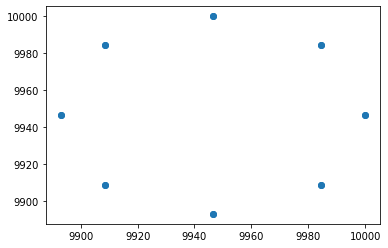

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# nanopore in nm
radius = 107 / 2
depth = 50
n_emitters = 8

# spacing = 42 #approx

center_nm = np.array([0, 0, 0])
max_angle = np.pi * 2
step = max_angle / n_emitters

points = np.zeros((n_emitters * 2, 3))
idx = 0
for z in [0, 50]:
    for i in range(n_emitters):
        angle = step * i
        d_x = np.cos(angle) * radius
        d_y = np.sin(angle) * radius
        point = center_nm + np.array([z, d_x, d_y])
        points[idx] = point
        idx += 1

points[:, 1] = points[:, 1] + points[:, 1].min() + 10000
points[:, 2] = points[:, 2] + points[:, 2].min() + 10000

plt.scatter(points[:, 1], points[:, 2])
plt.show()

points = np.array([
    [50, 10000, 10000],
    [0, 10000, 10000]
])



